In [ ]:
!pip install pandahouse

  Created wheel for pandahouse: filename=pandahouse-0.2.7-py2.py3-none-any.whl size=5921 sha256=f1580c8060ec64729ea7efc62d053c4982cd649529e3f234ba82ec449b3905a5
  Stored in directory: /root/.cache/pip/wheels/a5/21/86/0baf87a3ad07ced200fa982d25162c82bb099114382cdeaa46
Successfully built pandahouse


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

Настройки подключения к БД и функция запроса

In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220320'
}

def select(q):
    return pandahouse.read_clickhouse(q, connection=connection)

При помощи пакета lifelines построим две кривых выживаемости для пользователей из органического и рекламного трафика.  
Для этого необходимы данные о количестве дней проведенным пользователем в приложении.  
Также необходимо определить является ли пользователем ушедшим или нет.  
Поэтому сначала рассчитаем количество дней перерыва, после которого будем считать, что человек болеше не пользуется приложением.  
  

Получим данные о пользователе и дате его запуска приложения.  
Затем определим количество перерыв в использовании приложения для каждого пользователя.  
В таблице gap_data хранятся все перерывы в днях для всех пользователей.

In [ ]:
df = select("""
SELECT user_id , toDayOfYear(time) day FROM simulator_20220320.feed_actions 
GROUP BY user_id, day
ORDER BY user_id, day
""")

gap_data = df.groupby('user_id')['day'].diff()

Распределение перерывов в использовании приложения

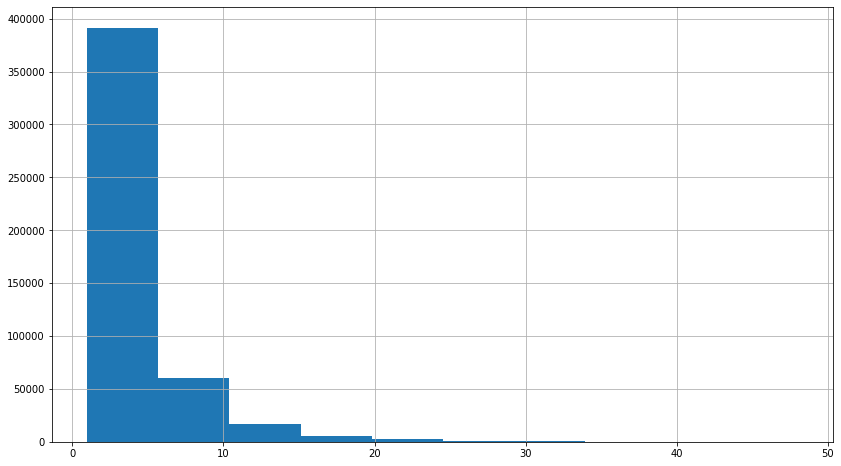

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
gap_data.hist(ax=ax)

Получим 95% квантиль этой выборки

In [ ]:
gap_data.quantile(0.95)
# через 11 дней не возвращаются 95% пользователей

11.0

Будем считать, что через 11 дней не возвращаются 95% пользователей.  
  
Получим данные о пользователе: id, количество дней с первого по последнего посещения, источник,  
если последнее посещение было раньше чем 11 дней назад, будем считать такого пользователя ушедшим (churn=1).

In [ ]:
df=select("""
SELECT user_id , 
       MAX(toDate(time)) - MIN(toDate(time)) days, 
       IF(MAX(toDate(time)) < today() - 11, 1, 0) churn,
       source 
FROM simulator_20220320.feed_actions 
WHERE toDate(time) < today()
GROUP BY user_id, source""")

Распределение Lifetime

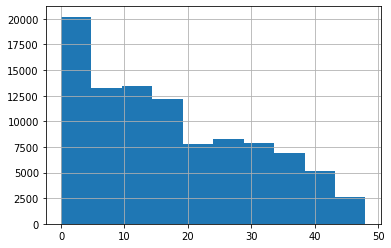

In [ ]:
df['days'].hist()

Создадим две кривые выживаемости для двух видов источников.  
Пользователи из органического трафика заметно чаще остаются, чем из рекламного.

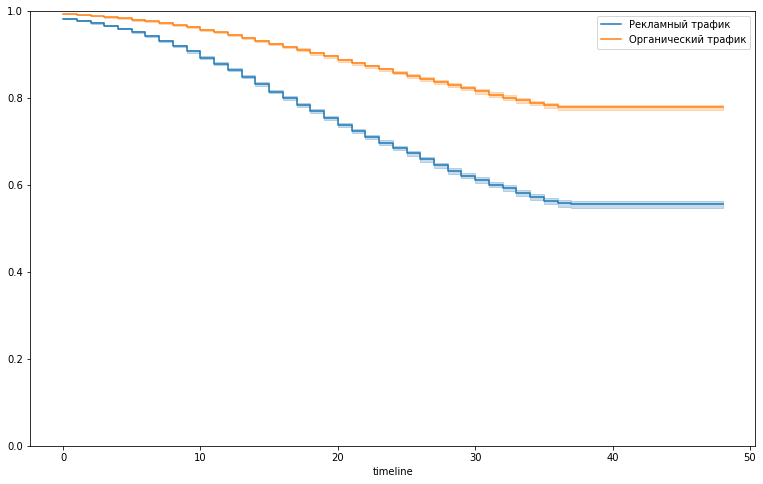

In [ ]:
ads = df[df['source']=='ads']
org = df[df['source']=='organic']

fig, ax = plt.subplots(figsize=(13, 8))

kmf = KaplanMeierFitter()
kmf.fit(durations=ads['days'], event_observed = ads['churn'], label='Рекламный трафик')
kmf.plot()

kmf.fit(durations=org['days'], event_observed = org['churn'], label='Органический трафик')
kmf.plot()
plt.ylim(0,1);

Для проверки статистически значемого различия двух кривых выживаемости используется лгранговый тест.

In [ ]:
results = logrank_test(ads['days'], org['days'], ads['churn'], org['churn'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3130.06 <0.005       inf

p-значение ниже 0.005, кривые выживаемости по признаку источника пользователей значемо отличаются.